<a href="https://colab.research.google.com/github/Henning-Kubatzsch/Tutorials/blob/main/01_micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Do the imports

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Create our Value Class

In [ ]:
#skeleton of the first object of micrograd
#micrograd is a scalar value engine -> so we only have scalar values -> Value(2.0)

class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    #_children=() is when initilaized an empty tuple: we use it as pointers so we know which vlues produce other values
    # using underscore means that the variable is intern or private
    self.data = data
    # gradient = 0 means that it has no effect on the output so it is not changing the loss function
    self.grad = 0.0
    # by default _backward is None, like for example in a leave node
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label


  # tgis is the representation function, like the toString method
  def __repr__(self):
    return f"Value(data={self.data})"

  # use double underscore to define methods for python objects
  def __add__(self, other):
    # isinstance(a,b) checks if a is an instance of the Value class
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    # _backward
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    # here we save the function, does not work with = _backward() //this would call the function but it's output is None as it has no return statement
    out._backward = _backward

    return out

  def __mul__(self, other):

    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += out.grad * other.data
      other.grad += out.grad * self.data

    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    # other is not an value object but an float or an int, so we not gonna save it
    out = Value(self.data ** other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * self.data ** (other -1) * out.grad
    out._backward = _backward

    return out

  # works in python cause it first looks for a __rmul__ method in the Int class -> as Int has no __rmul__ function it delegates it to the __rmul__ method of the other object
  # so in this case self will be the Value() object
  def __rmul__(self, other):
    return self * other

  def __radd__(self, other):
    return self + other

  def __truediv__(self, other):
    return self * other**-1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      # in this case out.data is the derivative of e^x
      self.grad += out.grad * out.data
    out._backward = _backward

    return out

  def backward(self):

    topo=[]
    visited = set()

    def built_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          built_topo(child)
        topo.append(v)
    built_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

#### test some operations

In [ ]:
a = Value(2.0)
b = Value(4.0)

a/b
a-b



Value(data=-2.0)

In [ ]:
# how to implement division?
# should be power full as
# a/b = a * (1/b) = a * (b**-1)
# so best way to implement is to implement x**k

### Import and implements logic for graph representation

In [ ]:
#following code is just for visualizing the expressions

from graphviz import Digraph

# trace enumarates all nodes and edges in the graph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    # building set of nodes and edges
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    # iterate through all nodes and create special objects for them using dot.node and edges with dot.edge
    for n in nodes:
        # here node objects are created
        dot.node(name=str(id(n)), label = "{ %s |data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        # here an fake node (operation node) gets created, means it is not actually containing an Value object
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            # here edges are created
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

### What is an activation function?

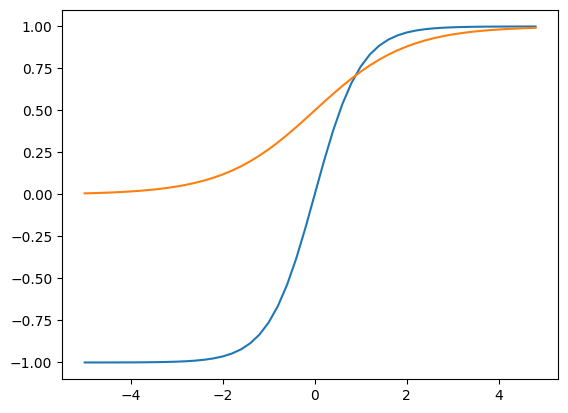

In [ ]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

# tanh: großer Bruder der Sigmoid Funktion
# unterschied: Wertebereich (-1,1)
xs = np.arange(-5,5,0.2)
plt.plot(xs, np.tanh(xs)); plt.grid()

plt.plot(xs, sigmoid(xs)); plt.grid()

### Draw concreate representation of arrithmetic graph

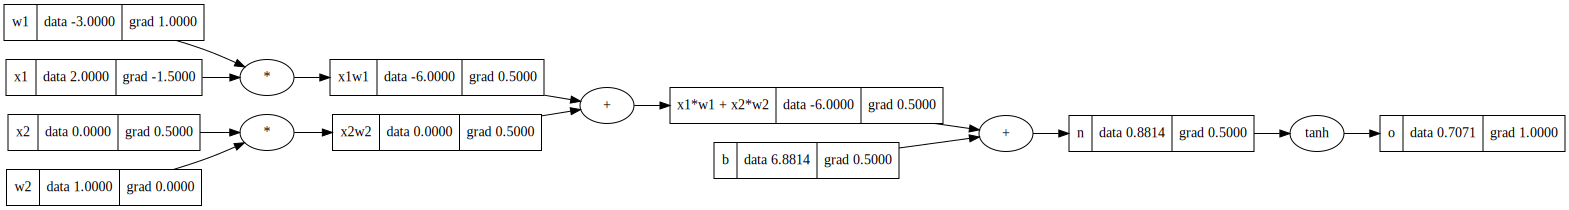

In [ ]:
# inputs x1, x2
x1 = Value(2.0, label='x1')

x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label= 'w2')

# bias of the neuron
# b = Value(6.7, label='b')
# when rising the bias the output is rising too
# b = Value(8, label='b')
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()
draw_dot(o)

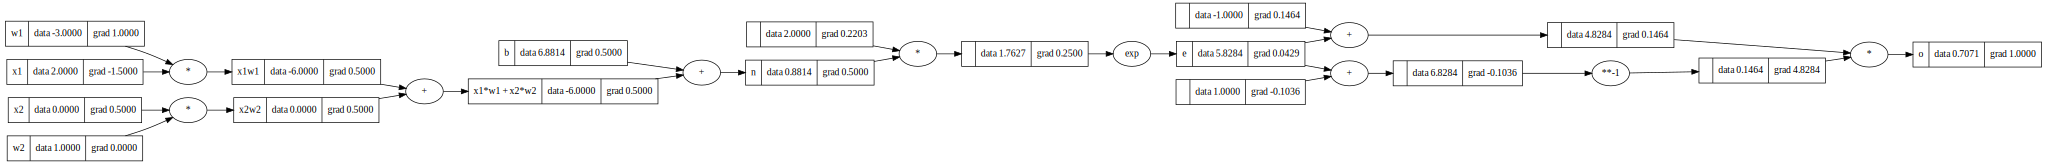

In [ ]:
# inputs x1, x2
x1 = Value(2.0, label='x1')

x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label= 'w2')

# bias of the neuron
# b = Value(6.7, label='b')
# when rising the bias the output is rising too
# b = Value(8, label='b')
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# --------
e = (2*n).exp(); e.label = 'e'

o = (e - 1) / (e + 1)
o.label = 'o'

o.backward()
draw_dot(o)

### Starting with pytorch

In [ ]:
import torch

# pytorch is working with Tensors, which are n-dimensional arrays of scalars
# to get a scalar tensor -> just give one argument when initializing
# also possible to initiate: torch.Tensor([[1,2,3], [3,4,5]])

# get a 2 * 3 Array
print(torch.Tensor([[1,2,3],[4,5,6]]).shape)
print(torch.Tensor([[1,2,3],[4,5,6]]))

# in our case we create a scalar Value tensor and we cast this value to be double
# by default it is using single percision float

print(torch.Tensor([2.0]).dtype)
print(torch.Tensor([2.0]).double().dtype)

p1 = torch.Tensor([2.123456789123456789])
p2 = torch.Tensor([2.123456789123456789]).double()
p3 = torch.tensor([2.123456789123456789], dtype=torch.float64)

print('\n')

print(p1.item())
print(p2.item())
print(p3.item())
print('\n')

p1.fill_(2.123456789123456789)
p2.fill_(2.123456789123456789)

print(p1.item())
print(p2.item())
print(p3.item())



torch.Size([2, 3])
tensor([[1., 2., 3.],
        [4., 5., 6.]])
torch.float32
torch.float64


2.1234567165374756
2.1234567165374756
2.123456789123457


2.1234567165374756
2.123456789123457
2.123456789123457


In [ ]:
# by default pytorch not expacts tensors to have gradients. We explicitly need to say that all nodes require these

x1 = torch.Tensor([2.0]).double()                   ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                   ; x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double()                  ; w1.requires_grad = True

w2 = torch.Tensor([1.0]).double()                   ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()     ; b.requires_grad = True
n = x1 * w1 + x2 * w2 + b

o = torch.tanh(n)

print(o.data.item())

o.backward()

print('____')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())


0.7071066904050358
____
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


In [ ]:
print(o)
print(o.item())
print('\n')

print("x2:             ",x2)
print("x2.grad:        ",x2.grad)
print("x2.grad.item(): ",x2.grad.item())

q1 = [1,2,3]
q2 = [4,5,6]
q3 = zip(q1, q2)
for didi in q3:
  print(didi)

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)
0.7071066904050358


x2:              tensor([0.], dtype=torch.float64, requires_grad=True)
x2.grad:         tensor([0.5000], dtype=torch.float64)
x2.grad.item():  0.5000001283844369
(1, 4)
(2, 5)
(3, 6)


### Implement MLP

#### MLP

In [ ]:
import random

class Neuron:

  def __init__(self,  nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    # b = bias -> controls the over all trigger happiness of neuron
    self.b = Value(random.uniform(-1,1))

  # __call__() is also called 'magic' or 'dunder' method -> allows an instance of a class to be called as a function
  # so you can invoke an object as if it were function
  def __call__(self, x):
    # w * x + b

    # wi*xi for wi, xi in zip(self.w, x) is the generator funtion -> must be parenthesized
    # sums all wi*xi with starting value self.b
    act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
    #print(act)

    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  # nout: number of neurons in that layer -> number of outputs
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    # gives a list of lists
    #return [neuron.parameters() for neuron in self.neurons]

    # flattens the list of lists, iterates through all parameters of all neurons and adds those to the list
    return [p for neuron in self.neurons for p in neuron.parameters()]

    #params = []
    #for neuron in self.neurons:
    #  params.extend(neuron.parameters())
    #return params

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]
    #params = []
    #for layer in self.layers:
    #  params.extend(layer.parameters())
    #return params


x = [2.0, 3.0, -1.0]
#n = Neuron(2)
#n1 = Layer(2, 3)
n2 = MLP(3, [4, 4, 1])

# print(n.__call__(x))
# print(n1(x))
print(n2(x))

# draw_dot(n2(x))


Value(data=-0.6117049777150373)


#### introduce training dataset and target value

In [ ]:
#lets work with an example small example data set
# in this case we have 4 inputs and 4 desired outputs
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

#ypred = [n2(x) for x in xs]
#ypred

In [ ]:
# how to start optimizing the network and tune the weights: calculate one single number that measures the over all performance of you network -> THE LOSS
# ygt = y ground truth
# here we print our losses
ypred = [n2(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=4.893020998415797)

In [ ]:
#now we have a really big graph :)
#draw_dot(loss)

In [ ]:
loss.backward()
# now our weights also have a grad:
# n2.layers[0].neurons[0].w[0].grad
n2.layers[0].neurons[0].w[0].grad


0.09670233073636522

In [ ]:
n2.layers[0].neurons[0].w[0].data


-0.5100499544122956

In [ ]:
# now gradient decent starts: we think about the gradient as a vector pointing in the direction of increased loss
# so we are now modifying p.data in the direction of the gradient

# example for one single weight of a neuron
# loss =    4
# w.grad = -0.2
# w.data =  2
# we want to minimize the loss, so we need to increase da data as the gradient (the derivative) is negative

for p in n2.parameters():
  # as the gradient is a vector pointing in the direction of increasing loss -> we want to move the opposite direction
  p.data += -0.01 * p.grad

In [ ]:
n2.layers[0].neurons[0].w[0].grad

0.09670233073636522

In [ ]:
n2.layers[0].neurons[0].w[0].data


-0.5110169777196593

#### For better visual overview:

- just remember: low loss means that our predictions are matching the targets
- in p.data += -0.01 * p.grad
  - -0.01 is our stepsize -> carefull with not choosing a too huge step size otherwise we could overstep our target

In [ ]:
ypred = [n2(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=4.443361091499505)

In [ ]:
loss.backward()

for p in n2.parameters():
  p.data += -0.01 * p.grad

ypred = [n2(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
print(loss)
print(ypred)


Value(data=3.6377070086500067)
[Value(data=-0.31811233907105724), Value(data=-0.3977819070034186), Value(data=-0.338135757998451), Value(data=-0.048597140882001906)]


#### Now we want to implement a training loop

In [ ]:
for k in range(20):

  #1: do the forward pass
  ypred = [n2(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  #2: zero_grad
  for p in n2.parameters():
    p.grad = 0

  #3: do the backward pass
  loss.backward()

  #4: update the weights and biasses
  for p in n2.parameters():
    p.data += -0.05 * p.grad

  print(k, loss)


0 Value(data=3.6377070086500067)
1 Value(data=2.743005162679647)
2 Value(data=2.014783273725772)
3 Value(data=1.099704551167685)
4 Value(data=0.5478080786768258)
5 Value(data=0.3455258114802998)
6 Value(data=0.24682228508899756)
7 Value(data=0.18920340584372583)
8 Value(data=0.15193733650927282)
9 Value(data=0.12610346088030813)
10 Value(data=0.10726810540586276)
11 Value(data=0.0929979418888025)
12 Value(data=0.0818550695782819)
13 Value(data=0.07293953124803426)
14 Value(data=0.06566148458954281)
15 Value(data=0.059619432437787875)
16 Value(data=0.05453129845486239)
17 Value(data=0.05019351446088601)
18 Value(data=0.046455740713214635)
19 Value(data=0.04320469980269921)


In [ ]:
ypred

[Value(data=0.9138109493745291),
 Value(data=-0.9300188239869457),
 Value(data=-0.8639311861077403),
 Value(data=0.8888062041084902)]

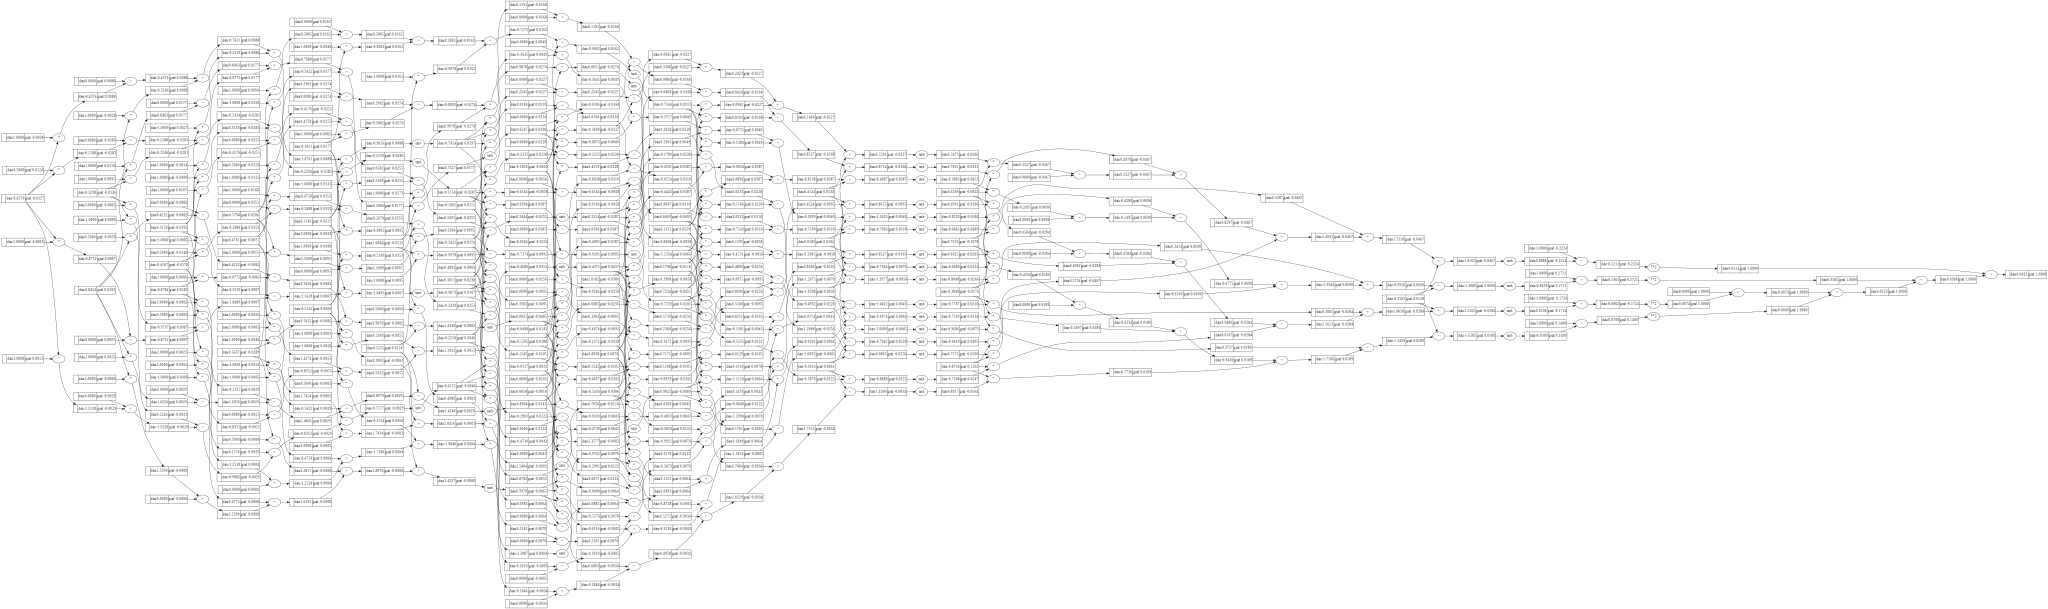

In [ ]:
draw_dot(loss)